In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch

import ResNet as net

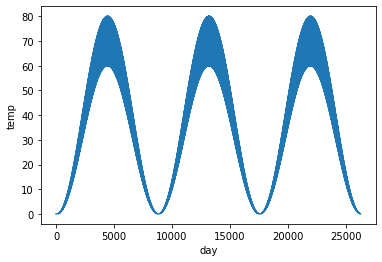

In [2]:
#toy problem in time
n_years = 3
day = np.arange(365*n_years)
hour = np.arange(24)
n_hour = len(hour)
n_trials = 10

# temp = np.zeros((n_trials, len(day) * n_hour, 2))


# for n in (range(n_trials)):
#     for i in range(len(day)):
        
#         for j in range(n_hour):
#             temp[n, i*n_hour + j, 1] = (10*np.cos(np.pi/12*(hour[j]+12))+70) * (0.5*np.cos(2*np.pi / 365*(day[i]+180)) + 0.5)
#             temp[n, i*n_hour + j, 0] = day[i] + hour[j]/ n_hour

temp = np.zeros( len(day) * n_hour)


for n in (range(n_trials)):
    for i in range(len(day)):
        
        for j in range(n_hour):
            temp[i*n_hour + j] = (10*np.cos(np.pi/12*(hour[j]+12))+70) * (0.5*np.cos(2*np.pi / 365*(day[i]+180)) + 0.5)
        
# x1 = 10*np.cos(np.pi/12*(hour+12))+70
# x2 = 0.5*np.cos(2*np.pi / 365*(day+180)) + 0.5

# noise = np.random.normal(0,1, temp.shape)
# temp[:,:, 1] += noise[:,:,1]


# plt.plot(temp[1, :,0], temp[1, :,1])
# plt.plot(temp[0, :,0], temp[0, :,1])
plt.plot(temp)
plt.xlabel("day")
plt.ylabel("temp")
plt.show()


In [3]:
# print(temp.shape)
# plt.plot(temp[0, 1000:1200,0], temp[0, 1000:1200,1])
# plt.plot(temp[1, 1000:1200,0], temp[1,1000:1200,1])
# plt.xlabel("day")
# plt.ylabel("temp")
# plt.show()

In [4]:
#want to train model on our time series
k = 5                         # model index: should be in {0, 2, ..., 10}
dt =    1                     # time unit: 0.0005 for Lorenz and 0.01 for others
# noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epoch = 100000            # the maximum training epoch 
batch_size = 320              # training batch size
arch = [5, 128, 128, 128, 5]  #[2, 128, 128, 128, 2] # architecture of the neural network

n_forward = 5
step_size = 2**k

length_year = 365*n_hour
print(temp.shape)
train_data = temp[:length_year]#temp[:,:length_year, 1] 
# train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
print(train_data.shape)
val_data = temp[length_year:(length_year*2)]#temp[:,length_year:(length_year*2), 1]
# val_data = val_data.reshape((val_data.shape[0], val_data.shape[1], 1))
print(val_data.shape)
test_data = temp[(length_year*2):(length_year*3)]#temp[:,(length_year*2):(length_year*3), 1]
# test_data= test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
print(test_data.shape)

n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]

# create dataset object
dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)

(26280,)
(8760,)
(8760,)
(8760,)
x_idx_start  = 0
x_idx_end  = 5
y_start_idx  = 5
y_end_idx  = 10
train.shape =  (8440, 11, 1)
train_data.shape =  (8760,)
2*step_size*n_forward =  320
train-x shape =  torch.Size([8440, 5, 1])
train_ys shape =  torch.Size([8440, 5, 1])
train-x shape =  torch.Size([8440, 5, 1])
val_xshape =  torch.Size([8440, 5, 1])
val_ys shape =  torch.Size([8440, 5, 1])


In [7]:
model_name = 'toy_problem1.pt'.format(step_size)#, noise)

# create/load model object
# try:
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model = torch.load(os.path.join(model_dir, model_name), map_location=device)
#     model.device = device
# except:
print('create model {} ...'.format(model_name))
model = net.ResNet(arch=arch, dt=dt, step_size=step_size)

# training
model.train_net(dataset, max_epoch=50000, batch_size=batch_size, lr=lr)

create model toy_problem1.pt ...
arch =  [5, 128, 128, 128, 5]
train_x.shape =  torch.Size([8440, 5, 1])
batch_x.shape =  torch.Size([320, 5, 1])
batch_ys.shape =  torch.Size([320, 5, 1])
y_prev shape =  torch.Size([320, 5, 1])
x_init shape =  torch.Size([320, 5, 1])


RuntimeError: size mismatch, m1: [1600 x 1], m2: [5 x 128] at C:\cb\pytorch_1000000000000\work\aten\src\TH/generic/THTensorMath.cpp:41

In [ ]:
start = 350
n_forward = 200
y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, start, :]).float(), n_steps=n_forward)
print(y_preds.shape)

plt.plot(y_preds[0,:,0])
plt.plot(test_data[0,start:start+n_forward,0])
plt.legend(["predicted", "Actual"])
plt.show()

error = torch.mean((y_preds[0,:]- test_data[0,start:start+n_forward])**2, 1)
print(((y_preds[0,:]- test_data[0,start:start+n_forward])**2).shape)
for i in range(1,10):
    error += torch.mean((y_preds[0,:]- test_data[0,start:start+n_forward])**2, 1)
print(error)
# plt.plot(np.abs(y_preds[0,:] - test_data[0,start:start+n_forward]))
plt.plot(error)
plt.title("error")
plt.show()

In [ ]:
y_preds = model.uni_scale_forecast(torch.tensor(train_data[:, 10]).float(), n_steps=20)
# print(y_preds[0,:,:])

plt.plot(y_preds[0,:])
plt.plot(y_preds[1,:])
plt.plot(train_data[0,10:30])
pl

plt.plot(train_data[1,10:30])
plt.legend(["predicted", "Actual"])

In [ ]:
#toy problem in space

x1 = np.random.normal(40, 10, (10,10))

for i in range(10):
    for j in range(10):
        x1[i,j] = abs(x1[i,j]) * (i+1)/(j+1) + np.random.normal(0,5)

# print(x1)
plt.imshow(x1) 
# plt.legend()
plt.colorbar()